# Maximum Entropy Forecasting Pipeline

This notebook demonstrates the full pipeline:
1. Generate relevant variables for a forecasting question
2. Generate probability/expectation estimates using natural language format
3. Build a maximum entropy distribution from the estimates

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

# Check API key is set
assert os.getenv("OPENROUTER_API_KEY"), "Set OPENROUTER_API_KEY in .env file"

## Step 1: Set up the LLM client and generators

In [3]:
from calibrated_response.llm.openrouter import OpenRouterClient
from calibrated_response.generation.variable_generator import VariableGenerator
from calibrated_response.generation.natural_estimate_generator import NaturalEstimateGenerator

# Initialize the LLM client
llm = OpenRouterClient(
    model="google/gemini-2.5-pro",
    providers=["Google"],  # Route to Google for best Gemini performance
)

# Initialize generators
var_gen = VariableGenerator(llm)
est_gen = NaturalEstimateGenerator(llm)

## Step 2: Define the forecasting question

In [4]:
question = """Will the AI bubble burst by the end of 2030, or will AI continue to grow and integrate into various industries, leading to sustained interest and investment?"""

print(f"Forecasting question: {question}")

Forecasting question: Will the AI bubble burst by the end of 2030, or will AI continue to grow and integrate into various industries, leading to sustained interest and investment?


## Step 3: Generate relevant variables

In [5]:
# Generate variables that might influence the forecast
variables = var_gen.generate(question, n_variables=10)

print(f"Generated {len(variables)} variables:\n")
for v in variables:
    print(f"  - {v.name} ({v.type.value}): {v.description}")
    if hasattr(v, 'lower_bound') and hasattr(v, 'upper_bound'):
        unit = getattr(v, 'unit', '') or ''
        print(f"    Domain: [{v.lower_bound}, {v.upper_bound}] {unit}")

Generated 10 variables:

  - ai_bubble_bursts (binary): Whether the AI sector experiences a 'bubble burst' (e.g., a >50% drop in value of major AI ETFs from their peak, sustained for 6+ months) by the end of 2030.
  - agi_milestone_achieved (binary): Whether a widely recognized milestone towards Artificial General Intelligence (AGI) is publicly demonstrated by a major lab by 2030.
  - fortune500_ai_revenue (continuous): The percentage of total revenue for Fortune 500 companies directly attributable to AI-driven products or services in 2029.
    Domain: [0.5, 40.0] percent
  - global_ai_vc_funding_2028 (continuous): Total global venture capital funding for AI-focused startups in the year 2028.
    Domain: [20.0, 500.0] billion_usd
  - major_ai_regulation_passed (binary): Whether major comprehensive AI-specific regulatory legislation is passed in the US or EU by the end of 2027 that significantly restricts AI development.
  - federal_funds_rate_2028 (continuous): The US Federal Reserve's

In [6]:
selected_vars = variables

## Step 4: Generate estimates using natural language format

In [8]:
# Generate estimates in natural language format
estimates = est_gen.generate(
    question=question,
    variables=selected_vars,
    num_estimates=50,
)

print(f"Generated {len(estimates)} estimates:\n")
for est in estimates:
    print(f"  {est.to_query_estimate()}")

Generated 50 estimates:

  P(ai_bubble_bursts = True) = 0.4
  P(agi_milestone_achieved = True) = 0.35
  E[fortune500_ai_revenue] = 8.5
  E[global_ai_vc_funding_2028] = 180.0
  P(major_ai_regulation_passed = True) = 0.7
  E[federal_funds_rate_2028] = 3.25
  E[advanced_chip_cost_2028] = 35000.0
  P(ai_caused_major_incident = True) = 0.15
  E[top5_ai_market_share] = 82.0
  P(new_tech_disruptor = True) = 0.2
  P(ai_bubble_bursts = True | fortune500_ai_revenue < 5.0) = 0.75
  P(ai_bubble_bursts = True | federal_funds_rate_2028 > 5.5) = 0.65
  P(ai_bubble_bursts = True | ai_caused_major_incident = True) = 0.85
  P(ai_bubble_bursts = True | new_tech_disruptor = True) = 0.6
  P(ai_bubble_bursts = True | agi_milestone_achieved = True) = 0.5
  E[fortune500_ai_revenue | ai_bubble_bursts = False] = 12.0
  E[global_ai_vc_funding_2028 | agi_milestone_achieved = True] = 350.0
  P(major_ai_regulation_passed = True | agi_milestone_achieved = True) = 0.95
  P(ai_caused_major_incident = True | agi_milest

In [1]:
# with open("maxent_llm_cache.pkl", "wb") as f:
#     import pickle
#     pickle.dump((variables, estimates), f)
with open("maxent_llm_cache.pkl", "rb") as f:
    import pickle
    variables, estimates = pickle.load(f)

In [2]:
from calibrated_response.maxent_large.distribution_builder import DistributionBuilder
from calibrated_response.maxent_large.maxent_solver import JAXSolverConfig


config = JAXSolverConfig(
    num_chains=2048,
    num_iterations=500,
    mcmc_steps_per_iteration=4,
    learning_rate=0.002,

    l2_regularization=1e-2,
    prior="gaussian",
    prior_std=0.5,
    hmc_step_size=0.015,
    hmc_leapfrog_steps=10,
    max_bins=15,
    seed=42,
    verbose=True,
)

builder = DistributionBuilder(variables=variables, estimates=estimates, solver_config=config)

# Build for AI bubble bursts (the solver trains once; marginals for all variables are in info)
distribution, info = builder.build(target_variable="ai_bubble_bursts")

print(f"\nConverged: {info['converged']}")
print(f"Features used: {info['n_features']}")
print(f"Skipped: {info['skipped_constraints']}")

[MaxEntSolver] iter   50  max_err=0.353679  mean_err=0.094986  accept=0.727  step_size=0.17201
[MaxEntSolver] iter  100  max_err=0.350523  mean_err=0.090327  accept=0.643  step_size=0.21816
[MaxEntSolver] iter  150  max_err=0.358153  mean_err=0.086393  accept=0.662  step_size=0.22650
[MaxEntSolver] iter  200  max_err=0.344745  mean_err=0.083227  accept=0.644  step_size=0.21276
[MaxEntSolver] iter  250  max_err=0.354789  mean_err=0.082175  accept=0.665  step_size=0.22089
[MaxEntSolver] iter  300  max_err=0.347737  mean_err=0.079766  accept=0.637  step_size=0.20749
[MaxEntSolver] iter  350  max_err=0.343810  mean_err=0.078120  accept=0.639  step_size=0.19490
[MaxEntSolver] iter  400  max_err=0.352743  mean_err=0.077242  accept=0.631  step_size=0.20235
[MaxEntSolver] iter  450  max_err=0.355347  mean_err=0.077396  accept=0.645  step_size=0.19008
[MaxEntSolver] iter  500  max_err=0.350663  mean_err=0.076065  accept=0.648  step_size=0.17855

Converged: False
Features used: 102
Skipped: []


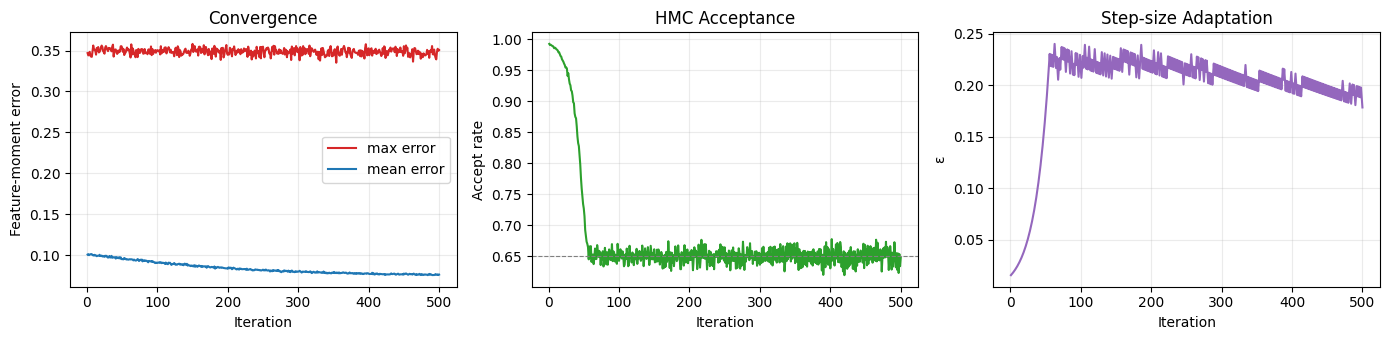

Final max error:  0.35066
Final mean error: 0.07607
Final accept rate: 0.648


In [3]:
import numpy as np
import matplotlib.pyplot as plt

history = info["history"]

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

axes[0].plot(history["iteration"], history["max_error"], label="max error", color="C3")
axes[0].plot(history["iteration"], history["mean_error"], label="mean error", color="C0")
axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Feature-moment error")
axes[0].set_title("Convergence"); axes[0].legend(); axes[0].grid(alpha=0.25)

axes[1].plot(history["iteration"], history["accept_rate"], color="C2")
axes[1].axhline(config.target_accept_rate, ls="--", color="gray", lw=0.8)
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Accept rate")
axes[1].set_title("HMC Acceptance"); axes[1].grid(alpha=0.25)

axes[2].plot(history["iteration"], history["step_size"], color="C4")
axes[2].set_xlabel("Iteration"); axes[2].set_ylabel("ε")
axes[2].set_title("Step-size Adaptation"); axes[2].grid(alpha=0.25)

plt.tight_layout(); plt.show()

print(f"Final max error:  {history['max_error'][-1]:.5f}")
print(f"Final mean error: {history['mean_error'][-1]:.5f}")
print(f"Final accept rate: {history['accept_rate'][-1]:.3f}")

In [4]:
model = info['energy_model']
import jax
samples = model.sample_original(n_samples=int(1e4))

In [ ]:
import seaborn as sns

# Plot all marginals in a grid
n_vars = len(variables)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()
    
for idx, var in enumerate(variables):
    sns.histplot(samples[:, idx], bins=20, kde=True, ax=axes[idx], color="C0")
    axes[idx].set_title(var.name, fontsize=11)
    axes[idx].set_xlabel(getattr(var, 'unit', '') or '', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_vars, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Marginal Distributions for All Variables', fontsize=14)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

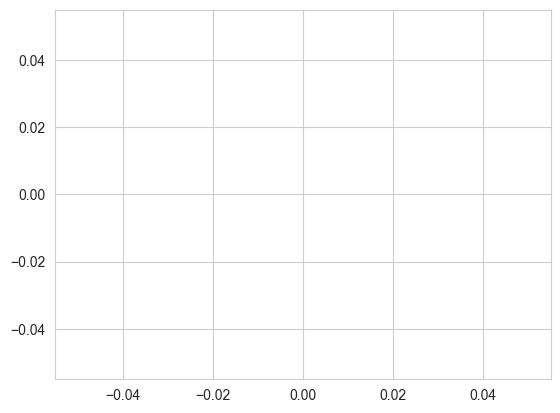

In [7]:
import seaborn as sns
sns.set_style("whitegrid")
i1, i2 = 0, 2
sns.kdeplot(x=samples[:, i1], y=samples[:, i2], fill=True, thresh=0.01, cmap="viridis")
plt.xlabel(variables[i1].name)
plt.ylabel(variables[i2].name)
plt.title(f"Joint Distribution of {variables[i1].name} and {variables[i2].name}")

## Step 5: Build the maximum entropy distribution

## Step 6: Visualize the distribution

## Step 7: Get all marginal distributions

In [21]:
# Get marginal distributions for all variables
all_marginals = builder.get_all_marginals(info)

print(f"Computed marginals for {len(all_marginals)} variables:")
for var_name, dist in all_marginals.items():
    bin_centers = (np.array(dist.bin_edges[:-1]) + np.array(dist.bin_edges[1:])) / 2
    mean = np.sum(np.array(dist.bin_probabilities) * bin_centers)
    print(f"  {var_name}: mean = {mean:.2f}, bins = {len(dist.bin_edges)-1}")

Computed marginals for 7 variables:
  ai_bubble_bursts_by_2030: mean = 0.45, bins = 2
  top_5_ai_firms_revenue_2029: mean = 403.88, bins = 10
  annual_ai_vc_funding_2029: mean = 157.68, bins = 10
  global_recession_before_2030: mean = 0.53, bins = 2
  top_model_mmlu_score_2028: mean = 95.01, bins = 10
  major_ai_regulation_enacted: mean = 0.61, bins = 2
  fortune_500_ai_adoption_2028: mean = 69.41, bins = 10


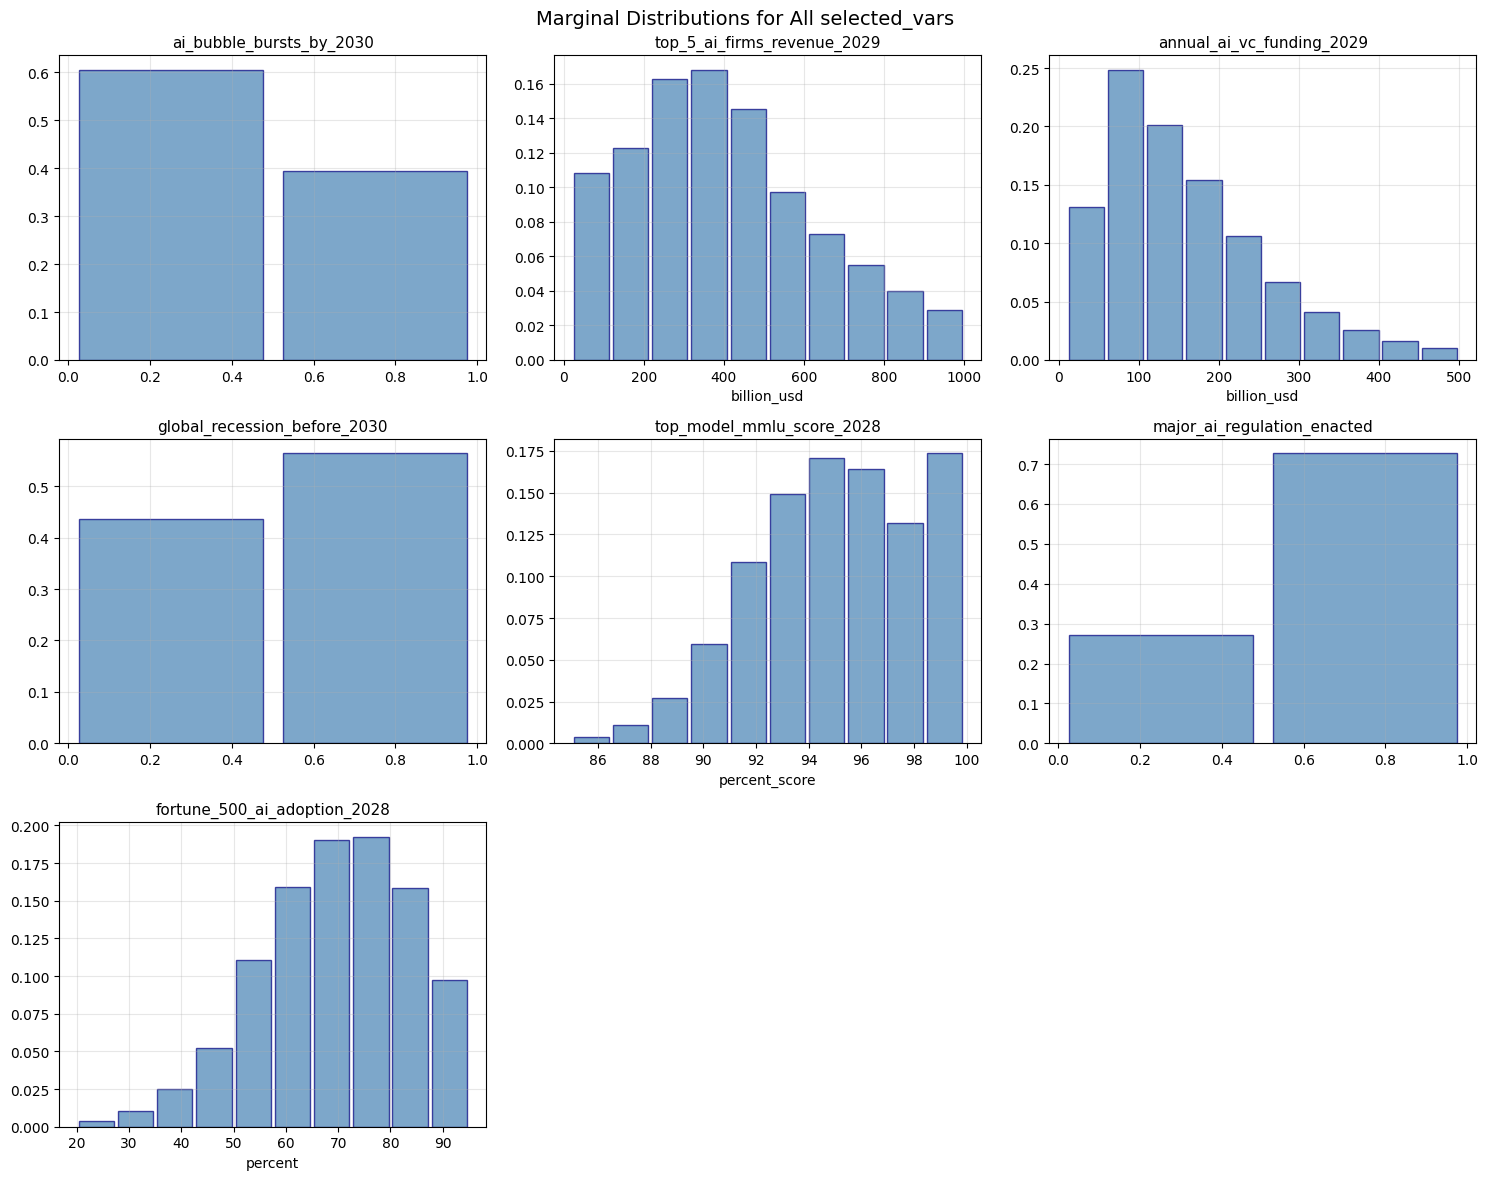

In [22]:
# Plot all marginals in a grid
n_vars = len(selected_vars)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, var in enumerate(selected_vars):
    ax = axes[idx]
    dist = all_marginals[var.name]
    
    bin_edges = np.array(dist.bin_edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    probs = np.array(dist.bin_probabilities)
    
    ax.bar(bin_centers, probs, width=bin_widths * 0.9, alpha=0.7, color='steelblue', edgecolor='navy')
    ax.set_title(var.name, fontsize=11)
    ax.set_xlabel(getattr(var, 'unit', '') or '', fontsize=10)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_vars, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Marginal Distributions for All selected_vars', fontsize=14)
plt.tight_layout()
plt.show()

## Step 8: Pairwise Marginal Plot

Visualize the relationships between all pairs of variables using a lower triangular plot.
- **Diagonal**: 1D marginal distributions with mean indicator
- **Lower triangle**: 2D joint marginal heatmaps
- **Upper triangle**: Empty (symmetric information)

The target variable is placed in the first row/column for easy comparison.

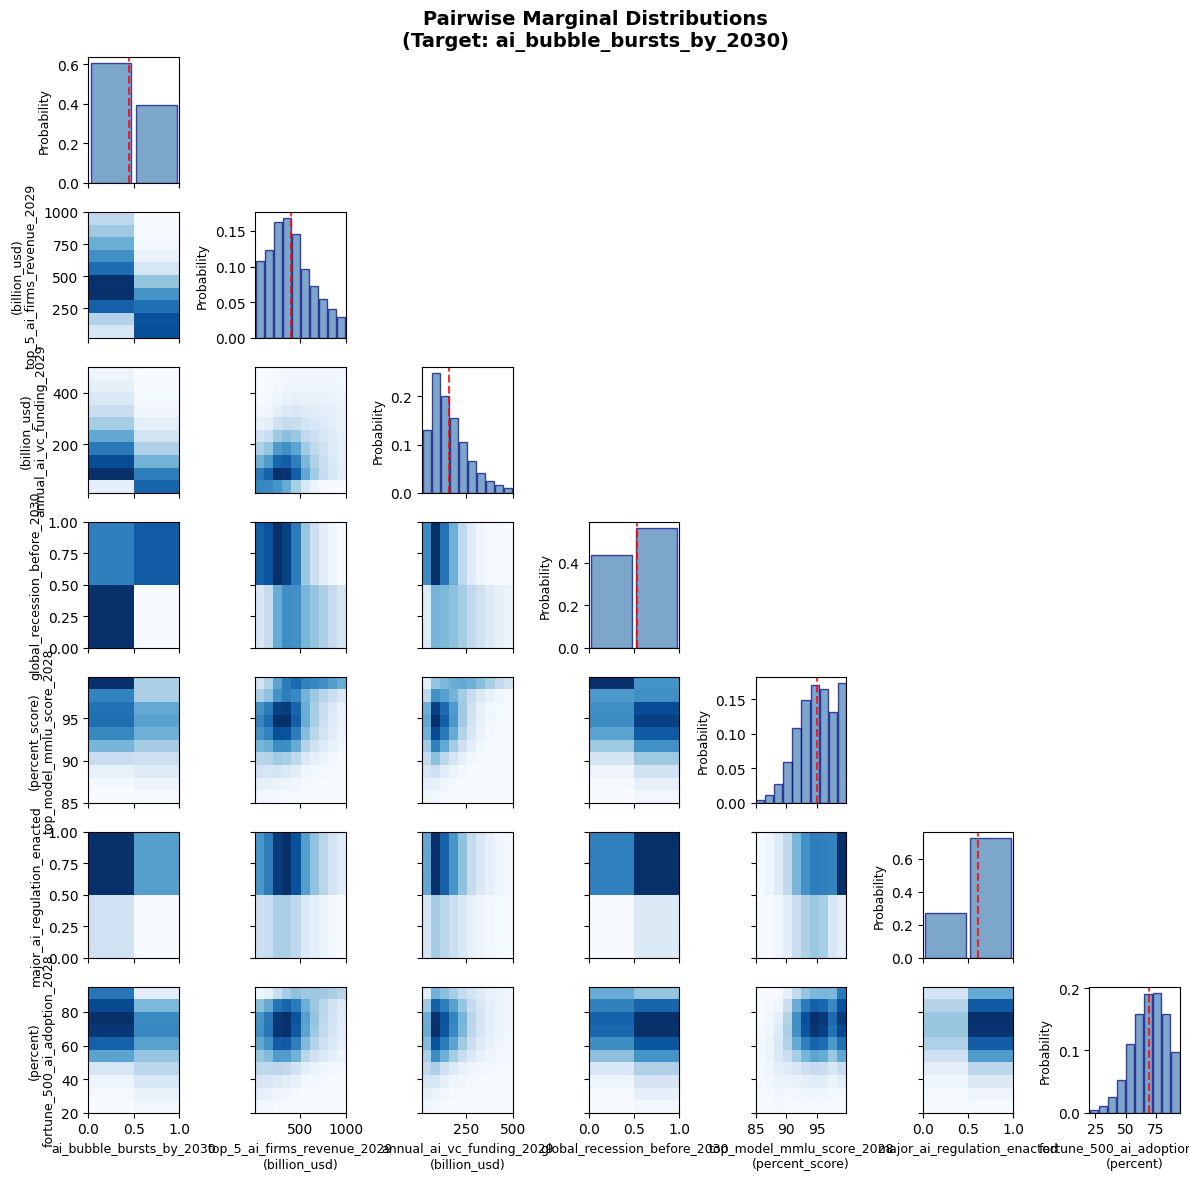

In [24]:
from calibrated_response.visualization.pairplot import plot_pairwise_marginals

# Get the joint distribution and bin edges from the last build
joint_dist = info['joint_distribution']
bin_edges = info['bin_edges_list']

# Create the pairwise plot
fig = plot_pairwise_marginals(
    joint_distribution=joint_dist,
    bin_edges_list=bin_edges,
    variables=selected_vars,
    target_variable=target_var.name,
    constraints=[], #builder.constraints,
    figsize=(12, 12),
    cmap='Blues',
)

plt.show()